<a href="https://colab.research.google.com/github/ua-datalab/Geospatial_Workshops/blob/main/notebooks/detecto_geospatial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will use a lightweight python library to download a pre-trained model and fine tune it to object detection in satellite imagery.

The [NWPU VHR-10 dataset](https://github.com/chaozhong2010/VHR-10_dataset_coco) is a very high resolution (VHR) geospatial dataset with ten classes of objects. In this example, we will train the model to identify these objects in the positive image set. The ground truth folder contains the object detection information in a plain text format.

This notebook uses **detecto**, a lightweight Python library that will allow us to create an object detection model in very few lines of code. It downloads a pre-trained Faster R-CNN ResNet50 FPN from Pytorch and fine tunes that on our task.

In [6]:
# install the required libraries
!pip install detecto --quiet
!pip install pascal-voc-writer --quiet

In [7]:
#Download the labeled training data set (NWPU_VHR-10.tar)
!wget https://github.com/ua-datalab/Geospatial_Workshops/raw/main/data/NWPU_VHR-10.tar

--2024-08-15 00:08:40--  https://github.com/ua-datalab/Geospatial_Workshops/raw/main/data/NWPU_VHR-10.tar
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ua-datalab/Geospatial_Workshops/main/data/NWPU_VHR-10.tar [following]
--2024-08-15 00:08:40--  https://raw.githubusercontent.com/ua-datalab/Geospatial_Workshops/main/data/NWPU_VHR-10.tar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77957120 (74M) [application/octet-stream]
Saving to: ‘NWPU_VHR-10.tar’

NWPU_VHR-10.tar     100%[===================>]  74.35M   227MB/s    in 0.3s    

2024-08-15 00:08:42 (227 MB/s) - ‘NWPU_VHR-10.tar’ saved [77

In [8]:
#Decompress the labeled training data tar file
!tar -xvf NWPU_VHR-10.tar

./NWPU_VHR-10_dataset/
./NWPU_VHR-10_dataset/readme.txt
./NWPU_VHR-10_dataset/.ipynb_checkpoints/
./NWPU_VHR-10_dataset/positive_image_set/
./NWPU_VHR-10_dataset/positive_image_set/515.jpg
./NWPU_VHR-10_dataset/positive_image_set/043.jpg
./NWPU_VHR-10_dataset/positive_image_set/450.jpg
./NWPU_VHR-10_dataset/positive_image_set/104.jpg
./NWPU_VHR-10_dataset/positive_image_set/212.jpg
./NWPU_VHR-10_dataset/positive_image_set/110.jpg
./NWPU_VHR-10_dataset/positive_image_set/092.jpg
./NWPU_VHR-10_dataset/positive_image_set/216.jpg
./NWPU_VHR-10_dataset/positive_image_set/195.jpg
./NWPU_VHR-10_dataset/positive_image_set/224.jpg
./NWPU_VHR-10_dataset/positive_image_set/533.jpg
./NWPU_VHR-10_dataset/positive_image_set/559.jpg
./NWPU_VHR-10_dataset/positive_image_set/535.jpg
./NWPU_VHR-10_dataset/positive_image_set/431.jpg
./NWPU_VHR-10_dataset/positive_image_set/052.jpg
./NWPU_VHR-10_dataset/positive_image_set/511.jpg
./NWPU_VHR-10_dataset/positive_image_set/037.jpg
./NWPU_VHR-10_dataset/posit

In [9]:
classes = {
    1: 'airplane',
    2: 'ship',
    3: 'storage tank',
    4: 'baseball diamond',
    5: 'tennis court',
    6: 'basketball court',
    7: 'ground track field',
    8: 'harbor',
    9: 'bridge',
    10: 'vehicle'
}

**detecto** requires that the dataset is labeled in the [Pascal VOC format](http://host.robots.ox.ac.uk/pascal/VOC/). In this dataset, the labels for the images are stored in plain text files, so we will first convert the data to the required format.

JEFF - your mileage may vary on whether or not you want to discuss file formats and include the following blocks of code. There's some good things buried here: 1) regular expressions for pattern matching, 2) the `if not numbers` line deals with a few edge cases of text files that have empty lines and will crash a naive implementation, so you have an in to talking about data cleaning 3) some exposure to reading and writing files and navigating file structures may be useful.

If you want to keep this, I can add a little diagram/explanation of the pascal voc format and further discussion on the following code. If you want to remove this section altogether, I can run this and give you the dataset in the correct format as a .tar file to be unpacked at the start of the notebook.

In [10]:
import os # used for looking through directories
import re # search in strings
from pascal_voc_writer import Writer # create the .xml files with the VOC format
from PIL import Image # used to get height, width of images

In [11]:
# get a list of the text file names
base = './NWPU_VHR-10_dataset'
txt_files = os.listdir(os.path.join(base, 'ground_truth'))

In [12]:
for txt in txt_files:
    # open the text file for reading
    with open(os.path.join(base, 'ground_truth', txt), 'r') as reader:

        # locate and open corresponding image
        img_id, _ = txt.split('.')
        img_path = os.path.join(base, 'positive_image_set', f'{img_id}.jpg')
        img = Image.open(img_path)

        # create a writer for the xml file
        xml_path = os.path.join(base, 'positive_image_set', f'{img_id}.xml')
        writer = Writer(img_path, img.width, img.height)

        # convert the text file to an xml file and save
        lines = reader.readlines()
        for line in lines:
            numbers = re.findall(r'\d+', line)
            if not numbers: # skip empty lines
                continue
            xmin, ymin, xmax, ymax, class_id = list(map(int, numbers))
            writer.addObject(classes[class_id], xmin, ymin, xmax, ymax)
        writer.save(xml_path)

Next, we load the 650 images into datasets and ensure that we can access images from that dataset. Because **detecto** is built on top of PyTorch, we will access a method from PyTorch's Dataset to create a random split between training, validation, and test datasets.

**detecto** provides a visualization function that will display the image along with bounding boxes and labels for the objects it contains.

JEFF - i can also create a version of the dataset where this is already done, i.e. the file structure is\
positive image set\
|-- training\
|-- test\
|-- validation\
Which may also smooth over this somewhat irritating edge of detecto and reduce confusion.

In [13]:
from detecto.core import Dataset
import torch
from torch.utils.data import random_split

# this sets the seed of the random generator to ensure reproducibility
random_generator = torch.Generator().manual_seed(42)

# create the datasets
dataset = Dataset(os.path.join(base, 'positive_image_set/'))
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1])

/usr/local/lib/python3.10/dist-packages/detecto/core.py:166: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  boxes = torch.tensor(boxes).view(-1, 4)


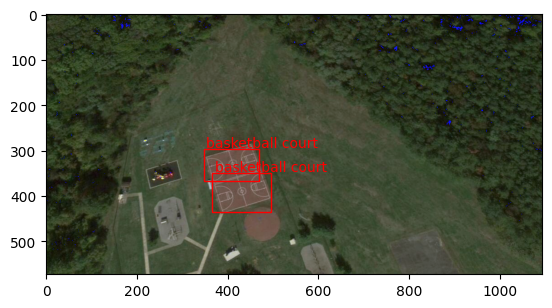

In [14]:
from detecto.visualize import show_labeled_image

# access and show some of the data
image, targets = train_dataset[36]
show_labeled_image(image, targets['boxes'], targets['labels'])

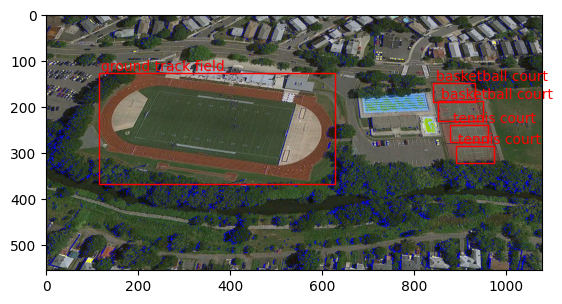

In [15]:
image, targets = test_dataset[2]
show_labeled_image(image, targets['boxes'], targets['labels'])

JEFF - the yellow is weird, I think this is an artifact of how detecto transforms the images upon loading them into the dataset but haven't looked directly at the code yet. It might be flipping the color channels? It's annoying but doesn't seem to impact performance. I might look into this further and see if I can get you a fix.

With the data loaded, we can now train the model. Here, we use a DataLoader to wrap the Dataset object. This allows us to specify the batch size used during each training step, one of a few hyperparameters we can play with during fine tuning.

Note that we are required to tell **detecto** which labels we are interested in learning to identify.

In [16]:
from detecto.core import DataLoader, Model

# wrap the training set in a DataLoader
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

# specify all unique labels you're trying to predict
labels = [
    'airplane',
    'ship',
    'storage tank',
    'baseball diamond',
    'tennis court',
    'basketball court',
    'ground track field',
    'harbor',
    'bridge',
    'vehicle'
]

In [ ]:
# initialize a model with the target labels and fit the model
model = Model(labels)
losses = model.fit(train_loader,
                   val_dataset,
                   epochs=8,
                   lr_step_size=5,
                   learning_rate=0.001,
                   verbose=True)

Here we perform a sanity check to ensure that the training process is working correctly by checking that the loss is decreasing.

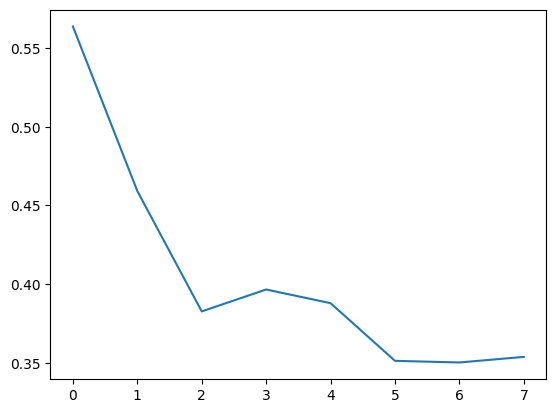

In [ ]:
from matplotlib import pyplot as plt

plt.plot(losses)
plt.show()

In [ ]:
model.save('detecto_vhr_finetune.pth')

NameError: name 'model' is not defined

In [3]:
!wget https://huggingface.co/jgillan/detecto_vhr_finetune/resolve/main/detecto_vhr_finetune.pth

--2024-08-14 23:56:19--  https://huggingface.co/jgillan/detecto_vhr_finetune/resolve/main/detecto_vhr_finetune.pth
Resolving huggingface.co (huggingface.co)... 18.244.202.60, 18.244.202.73, 18.244.202.68, ...
Connecting to huggingface.co (huggingface.co)|18.244.202.60|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/2a/1b/2a1b5d6471b63cd92461ef557884bccd94e9c0ccc0f6a3aa37af756b838e38fb/528abd6a688d57c2b166157465f52c50f08ff48613b3e09580dbea9bff5c9215?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27detecto_vhr_finetune.pth%3B+filename%3D%22detecto_vhr_finetune.pth%22%3B&Expires=1723938979&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyMzkzODk3OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzJhLzFiLzJhMWI1ZDY0NzFiNjNjZDkyNDYxZWY1NTc4ODRiY2NkOTRlOWMwY2NjMGY2YTNhYTM3YWY3NTZiODM4ZTM4ZmIvNTI4YWJkNmE2ODhkNTdjMmIxNjYxNTc0NjVmNTJjNTBmMDhmZ

In [17]:
#Load pre-trained model from hugging face
model = Model.load('detecto_vhr_finetune.pth', labels)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 117MB/s]


Now that the model is trained, we can run it on a few test images to check the performance. One trade off of using **detecto** is that it does not give you access to the PyTorch methods that allow you to calculate accuracy on the test set, so this will be a qualitative check rather than a quantitative one. If your project requires this, I'd suggest using detecto as a first pass at seeing if this architecture will work for your task, and if so, a second pass using PyTorch is in order.

In [18]:
images = []
for i in range(4):
    image, _ = test_dataset[i]
    images.append(image)

top_predictions = model.predict_top(images)
print(top_predictions)

[(['airplane', 'baseball diamond'], tensor([[317.9532, 653.2673, 417.8381, 763.8511],
        [352.7748, 236.5977, 460.0860, 336.7590]]), tensor([0.9896, 0.8267])), (['vehicle', 'storage tank', 'bridge', 'baseball diamond'], tensor([[184.9300, 108.6330, 228.6270, 164.0019],
        [ 88.0771, 448.2318, 174.7319, 498.3453],
        [327.0400,   4.2582, 443.0012,  98.8639],
        [304.0408, 292.9612, 362.9582, 364.2414]]), tensor([0.9837, 0.0550, 0.0940, 0.0572])), (['ground track field', 'basketball court', 'bridge', 'tennis court'], tensor([[ 98.6337, 119.2821, 616.3807, 355.1165],
        [844.5160, 187.4128, 950.0386, 234.0464],
        [212.8492, 157.5376, 620.4022, 355.8943],
        [866.8334, 237.3265, 960.5496, 277.2844]]), tensor([0.9499, 0.9823, 0.0560, 0.9763])), (['ground track field', 'ship', 'bridge', 'tennis court'], tensor([[  69.5895,  197.7037,  216.5267,  426.8160],
        [1127.3204,  186.9677, 1188.0212,  332.0643],
        [ 562.3737,  118.4757,  674.2646,  282.

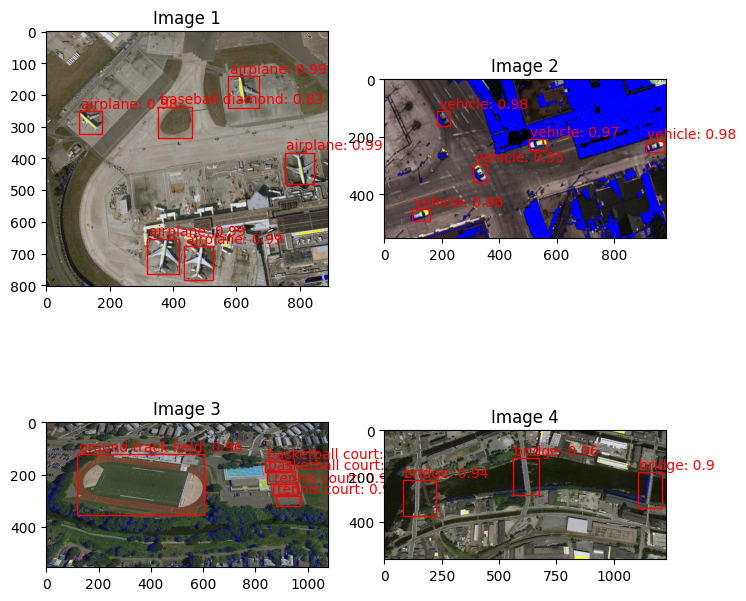

In [19]:
from detecto.visualize import plot_prediction_grid

plot_prediction_grid(model, images, dim=(2, 2), figsize=(8, 8))